In [2]:
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

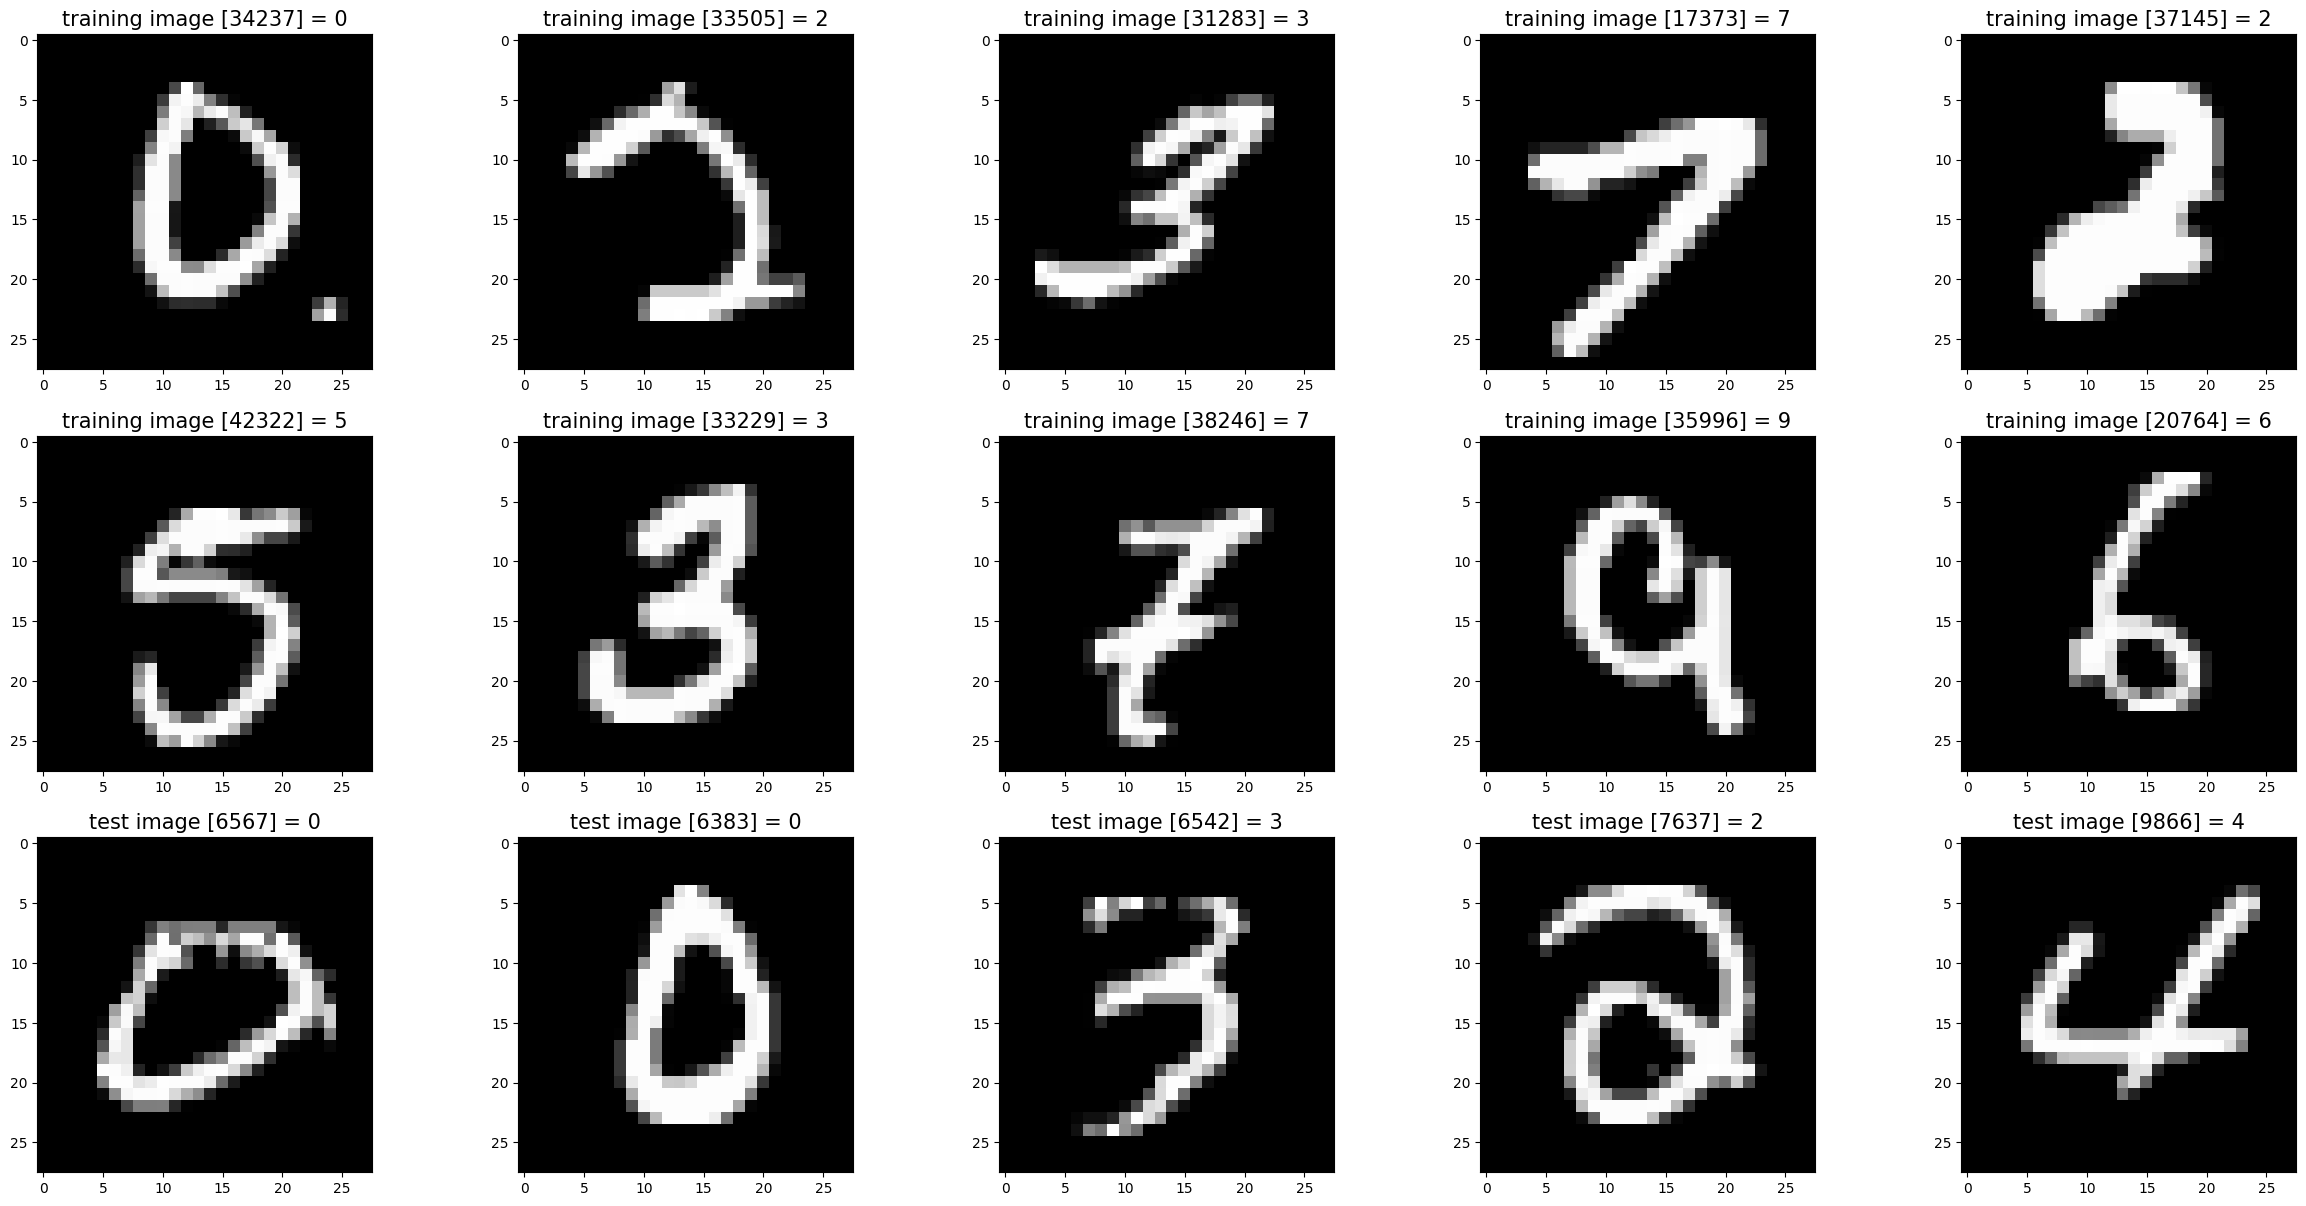

In [13]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = '../1-NN-prototype-algo'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [26]:
import numpy as np
from sklearn.cluster import KMeans

def select_prototypes_kmeans(x_train, y_train, num_prototypes):
    """
    Enhanced prototype selection with debugging information.
    """
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    # Flatten images
    x_flat = np.array([img.flatten() for img in x_train])
    
    print(f"Training data shape: {x_train.shape}")
    print(f"Flattened data shape: {x_flat.shape}")
    print(f"Number of prototypes requested: {num_prototypes}")
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=min(num_prototypes, len(x_train)), random_state=42)
    kmeans.fit(x_flat)
    
    # Find closest points to cluster centers (prototypes)
    prototype_indices = []
    for center in kmeans.cluster_centers_:
        # Find the training point closest to each cluster center
        distances = np.linalg.norm(x_flat - center, axis=1)
        closest_idx = np.argmin(distances)
        prototype_indices.append(closest_idx)
    
    # Select prototype images and labels
    prototype_images = x_train[prototype_indices]
    prototype_labels = y_train[prototype_indices]
    
    print(f"Prototype images shape: {prototype_images.shape}")
    print(f"Prototype labels shape: {prototype_labels.shape}")
    
    return prototype_images, prototype_labels

def custom_1nn_classifier(test_image, prototypes, prototype_labels):
    """Custom 1-NN classifier with float64 conversion."""
    # Ensure float64 conversion
    test_image_flat = test_image.flatten().astype(np.float64)
    prototype_flat = np.array([img.flatten().astype(np.float64) for img in prototypes])
    
    # Calculate distances
    distances = np.linalg.norm(prototype_flat - test_image_flat, axis=1)
    
    # Find nearest prototype
    nearest_idx = np.argmin(distances)
    
    return prototype_labels[nearest_idx]

def evaluate_prototype_selection(x_train, y_train, x_test, y_test, num_prototypes):
    """
    Evaluate prototype selection with more detailed logging.
    """
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    # Select prototypes using K-means
    prototypes, prototype_labels = select_prototypes_kmeans(
        x_train, y_train, num_prototypes
    )
    
    # Predict labels for test set
    predictions = []
    for test_image in x_test:
        pred = custom_1nn_classifier(test_image, prototypes, prototype_labels)
        predictions.append(pred)
    
    # Calculate accuracy
    accuracy = np.mean(np.array(predictions) == y_test)
    
    print(f"Unique training labels: {np.unique(y_train)}")
    print(f"Unique prototype labels: {np.unique(prototype_labels)}")
    print(f"Unique prediction labels: {np.unique(predictions)}")
    
    return accuracy, prototypes, prototype_labels

In [27]:
# Call the function and print accuracy percentage
accuracy, prototypes, prototype_labels = evaluate_prototype_selection(x_train, y_train, x_test, y_test, 1000)
print(f"Accuracy on test data: {accuracy * 100:.2f}%")

Training data shape: (60000, 28, 28)
Flattened data shape: (60000, 784)
Number of prototypes requested: 1000
Prototype images shape: (1000, 28, 28)
Prototype labels shape: (1000,)
Unique training labels: [0 1 2 3 4 5 6 7 8 9]
Unique prototype labels: [0 1 2 3 4 5 6 7 8 9]
Unique prediction labels: [0 1 2 3 4 5 6 7 8 9]
Accuracy on test data: 92.31%


In [28]:
import numpy as np

def random_prototype_selection(x_train, y_train, num_prototypes, random_state=42):
    """
    Randomly select prototypes while maintaining label distribution.
    
    Args:
        x_train (numpy.ndarray): Training images
        y_train (numpy.ndarray): Training labels
        num_prototypes (int): Number of prototypes to select
        random_state (int): Random seed for reproducibility
    
    Returns:
        tuple: Selected prototype images and their corresponding labels
    """
    # Ensure numpy arrays and float64
    x_train = np.array(x_train, dtype=np.float64)
    y_train = np.array(y_train)
    
    # Get unique labels
    unique_labels = np.unique(y_train)
    
    # Calculate prototypes per label (proportional to original distribution)
    prototypes_per_label = np.round(
        num_prototypes * np.bincount(y_train) / len(y_train)
    ).astype(int)
    
    # Adjust to ensure total matches num_prototypes
    while np.sum(prototypes_per_label) != num_prototypes:
        if np.sum(prototypes_per_label) < num_prototypes:
            prototypes_per_label[np.argmin(prototypes_per_label)] += 1
        else:
            prototypes_per_label[np.argmax(prototypes_per_label)] -= 1
    
    # Set random seed
    np.random.seed(random_state)
    
    # Select prototypes
    prototype_images = []
    prototype_labels = []
    
    for label, num_proto in zip(unique_labels, prototypes_per_label):
        # Find indices of images with this label
        label_indices = np.where(y_train == label)[0]
        
        # Randomly select prototypes for this label
        selected_indices = np.random.choice(
            label_indices, 
            size=num_proto, 
            replace=False
        )
        
        prototype_images.append(x_train[selected_indices])
        prototype_labels.append(y_train[selected_indices])
    
    # Concatenate results
    prototype_images = np.concatenate(prototype_images)
    prototype_labels = np.concatenate(prototype_labels)
    
    return prototype_images, prototype_labels

def custom_1nn_classifier(test_image, prototypes, prototype_labels):
    """Custom 1-NN classifier with float64 conversion"""
    test_image_flat = test_image.flatten().astype(np.float64)
    prototype_flat = np.array([img.flatten().astype(np.float64) for img in prototypes])
    
    # Calculate distances
    distances = np.linalg.norm(prototype_flat - test_image_flat, axis=1)
    
    # Find nearest prototype
    nearest_idx = np.argmin(distances)
    
    return prototype_labels[nearest_idx]

def evaluate_prototype_selection(x_train, y_train, x_test, y_test, num_prototypes):
    """Evaluate random prototype selection"""
    # Convert to float64
    x_train = np.array(x_train, dtype=np.float64)
    y_train = np.array(y_train)
    x_test = np.array(x_test, dtype=np.float64)
    y_test = np.array(y_test)
    
    # Select prototypes randomly
    prototypes, prototype_labels = random_prototype_selection(
        x_train, y_train, num_prototypes
    )
    
    # Predict labels for test set
    predictions = []
    for test_image in x_test:
        pred = custom_1nn_classifier(test_image, prototypes, prototype_labels)
        predictions.append(pred)
    
    # Calculate accuracy
    accuracy = np.mean(np.array(predictions) == y_test)
    
    return accuracy, prototypes, prototype_labels

In [29]:
# Call the function and print accuracy percentage
accuracy, prototypes, prototype_labels = evaluate_prototype_selection(x_train, y_train, x_test, y_test, 100)
print(f"Accuracy on test data: {accuracy * 100:.2f}%") 

Accuracy on test data: 70.96%
